In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import dynamo as dyn
import spateo as st
warnings.filterwarnings("ignore")

2023-09-25 20:06:09.368085: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 20:06:09.389936: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 20:06:09.720872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cpo = [(278, 1174, 131), (13, 8, -3), (0, 0, 1)]
mapping_cpo = [(-28, 1021, -119), (-29, 9, -152), (0, 0, 1)]

In [3]:
tissue, morpho_id = "salivary gland", "morphogenesis"
sample_id1, sample_id2 = "E7_8h", "E8_9h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot")

out_image_path = f"drosophila_{sample_id1}_germ_layer/image/morphogenesis_{tissue}"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [4]:
# Read anndata
stage1_adata = st.read_h5ad(f"drosophila_{sample_id1}/h5ad/{sample_id1}_cellbin_clean.h5ad")
stage1_adata.X = stage1_adata.layers["X_counts"]
stage1_adata.obsm["3d_align_spatial"] = stage1_adata.obsm["tdr_spatial"]
stage1_adata = stage1_adata[stage1_adata.obs["anno_tissue_new"] == tissue, :]
stage1_adata = stage1_adata[stage1_adata.X.sum(axis=1) != 0, stage1_adata.X.sum(axis=0) != 0]
sc.pp.normalize_total(adata=stage1_adata)
sc.pp.log1p(stage1_adata)
stage2_adata = st.read_h5ad(f"drosophila_{sample_id2}/h5ad/{sample_id2}_cellbin_v2_{tissue}.h5ad")
stage2_adata.X = stage2_adata.layers["X_counts"]
stage2_adata = stage2_adata[stage2_adata.X.sum(axis=1) != 0, stage2_adata.X.sum(axis=0) != 0]
sc.pp.normalize_total(adata=stage2_adata)
sc.pp.log1p(stage2_adata)
print(stage1_adata, stage2_adata)

AnnData object with n_obs × n_vars = 360 × 5819
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    uns: 'log1p'
    obsm: '2d_realign_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', '3d_align_spatial'
    layers: 'X_counts', 'spliced', 'unspliced' AnnData object with n_obs × n_vars = 566 × 6521
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new'
    uns: 'log1p'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'


## Mapping

In [5]:
# Cell mapping
_, pi = st.tdr.cell_directions(
    adataA=stage1_adata,
    adataB=stage2_adata,
    numItermaxEmd=1000000,
    # G_init=pi_init,
    spatial_key="3d_align_spatial",
    key_added="cells_mapping",
    alpha=0.0001,
    device="0",
    inplace=True,
)

|-----> Filtered all samples for common genes. There are 5249 common genes.


## Check mapping result

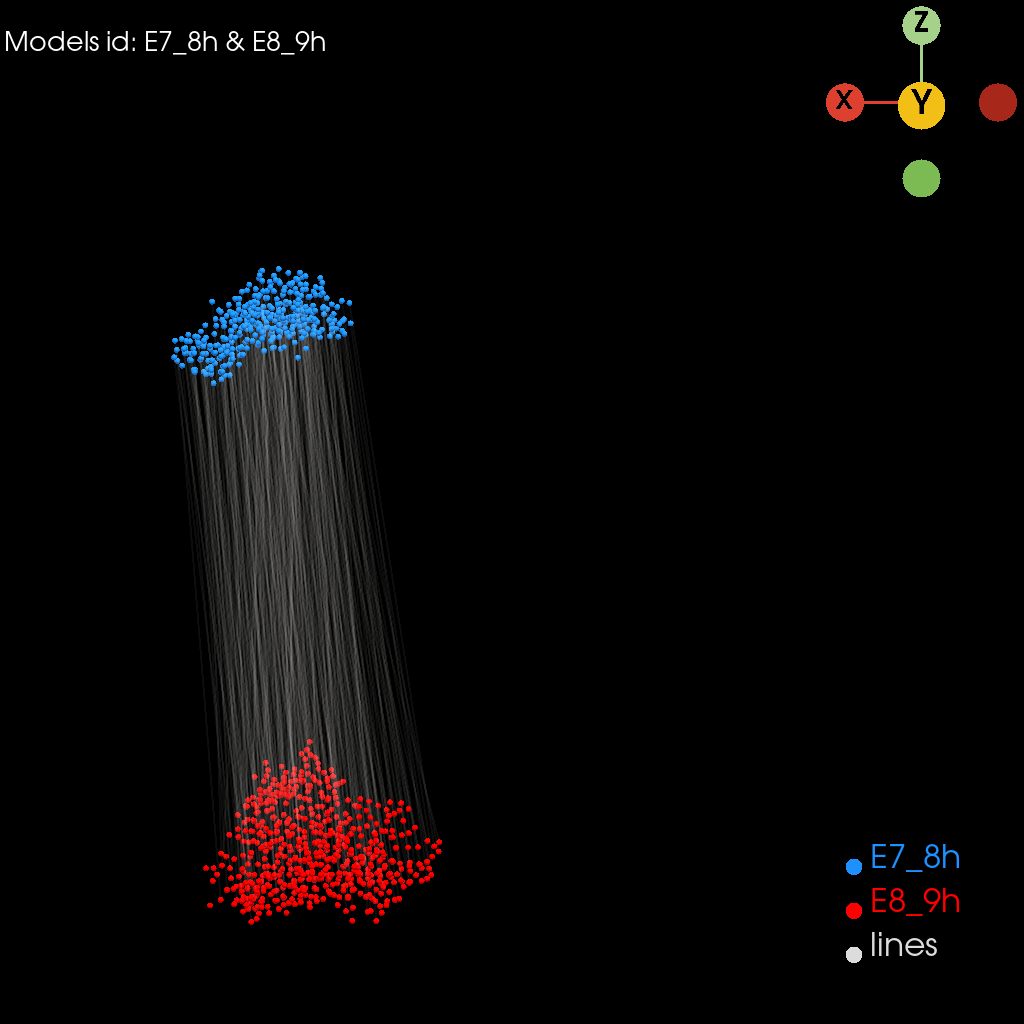

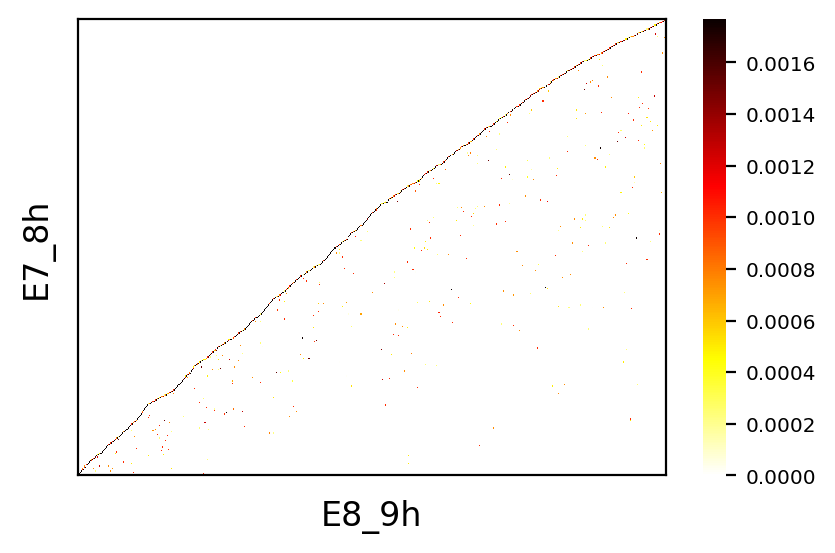

In [10]:
# Check mapping result
st.pl.pi_heatmap(
    pi=pi,
    model1_name=sample_id1,
    model2_name=sample_id2,
    filename=os.path.join(
        out_image_path, f"{sample_id1}-{sample_id2}_{tissue}_mapping_heatmap.png"
    ),
)
st.pl.pairwise_mapping(
    idA=sample_id1,
    idB=sample_id2,
    adataA=stage1_adata.copy(),
    adataB=stage2_adata.copy(),
    pi=pi.copy(),
    spatial_key="3d_align_spatial",
    cpo=mapping_cpo,
    jupyter="static",
    filename=os.path.join(out_image_path, f"{sample_id1}-{sample_id2}_{tissue}_mapping_z_model.png"),
)

## Vector field

In [11]:
stage1_pc, _ = st.tdr.construct_pc(adata=stage1_adata, spatial_key="3d_align_spatial", groupby="anno_tissue_new", key_added="tissue")
stage1_mesh = st.tdr.read_model(f"drosophila_{sample_id1}/mesh_models_new/5_SalivaryGland_{sample_id1}_aligned_mesh_model.vtk")

In [12]:
st.tdr.morphofield(
    adata=stage1_adata,
    spatial_key="3d_align_spatial",
    V_key="V_cells_mapping",
    key_added="VecFld_morpho",
    NX=np.asarray(stage1_mesh.points),
    inplace=True,
)
stage1_pc.point_data["vectors"] = stage1_adata.uns["VecFld_morpho"]["V"]
stage1_mesh.point_data["vectors"] = stage1_adata.uns["VecFld_morpho"]["grid_V"]

|-----? The length of [  0 100 200 300 400] is different from 10, using `np.range(restart_num) * 100
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.0704s]
|-----> [morphofield] in progress: 100.0000%
|-----> [morphofield] finished [57.2071s]


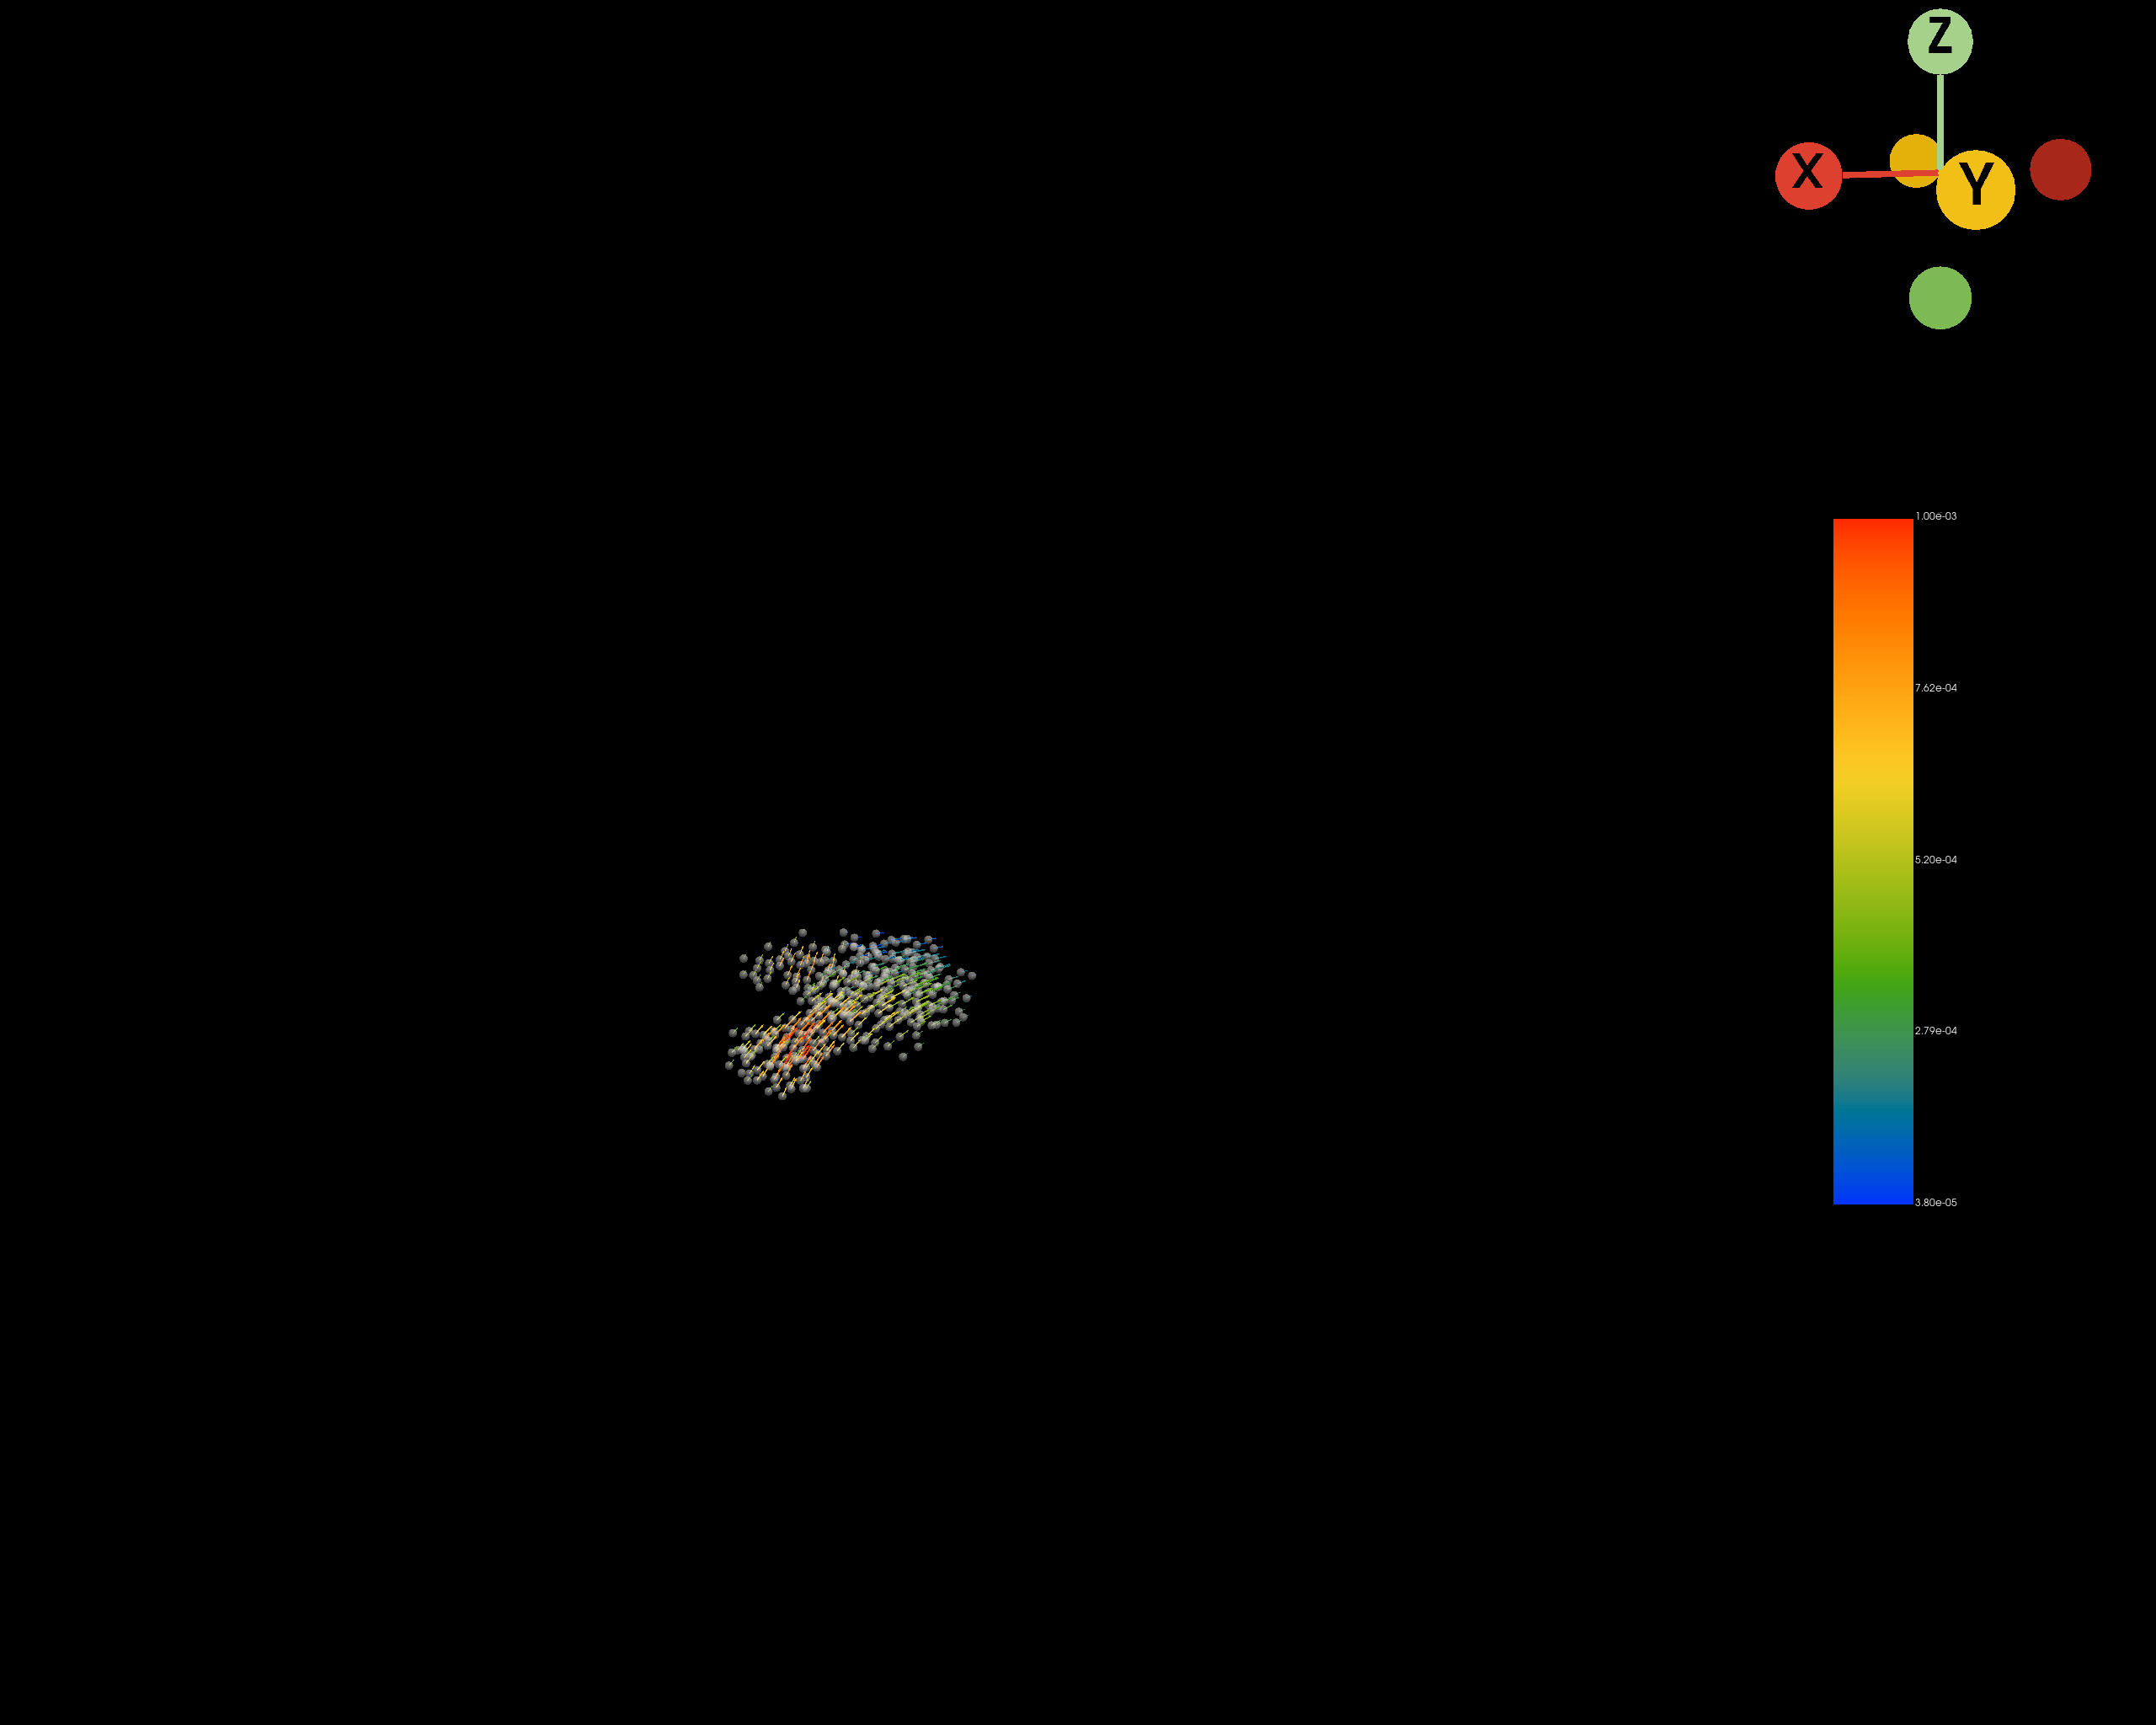

In [13]:
vector_arrows1,_ = st.tdr.construct_field(
    model=stage1_pc,
    vf_key="vectors",
    arrows_scale_key="vectors",
    n_sampling=None,
    factor=5000,
    key_added="v_arrows",
    label=stage1_pc.point_data["vectors"][:, 2].flatten(),
    color= "rainbow",
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_pc, vector_arrows1]),
    key=["tissue", "v_arrows"],
    colormap=["gainsboro", "rainbow"],
    opacity=[0.5, 1],
    model_style=["points", "surface"],
    model_size=[10, 5],
    show_legend=True,
    jupyter="static",
    background="black",
    window_size=(2560, 2048),
    cpo=cpo,
    filename=os.path.join(out_image_path, f"{morpho_id}_{tissue}_vector_arrows_pc_model.pdf")
)

|-----> [Running TRN] in progress: 100.0000%|-----> [Running TRN] completed [0.8792s]


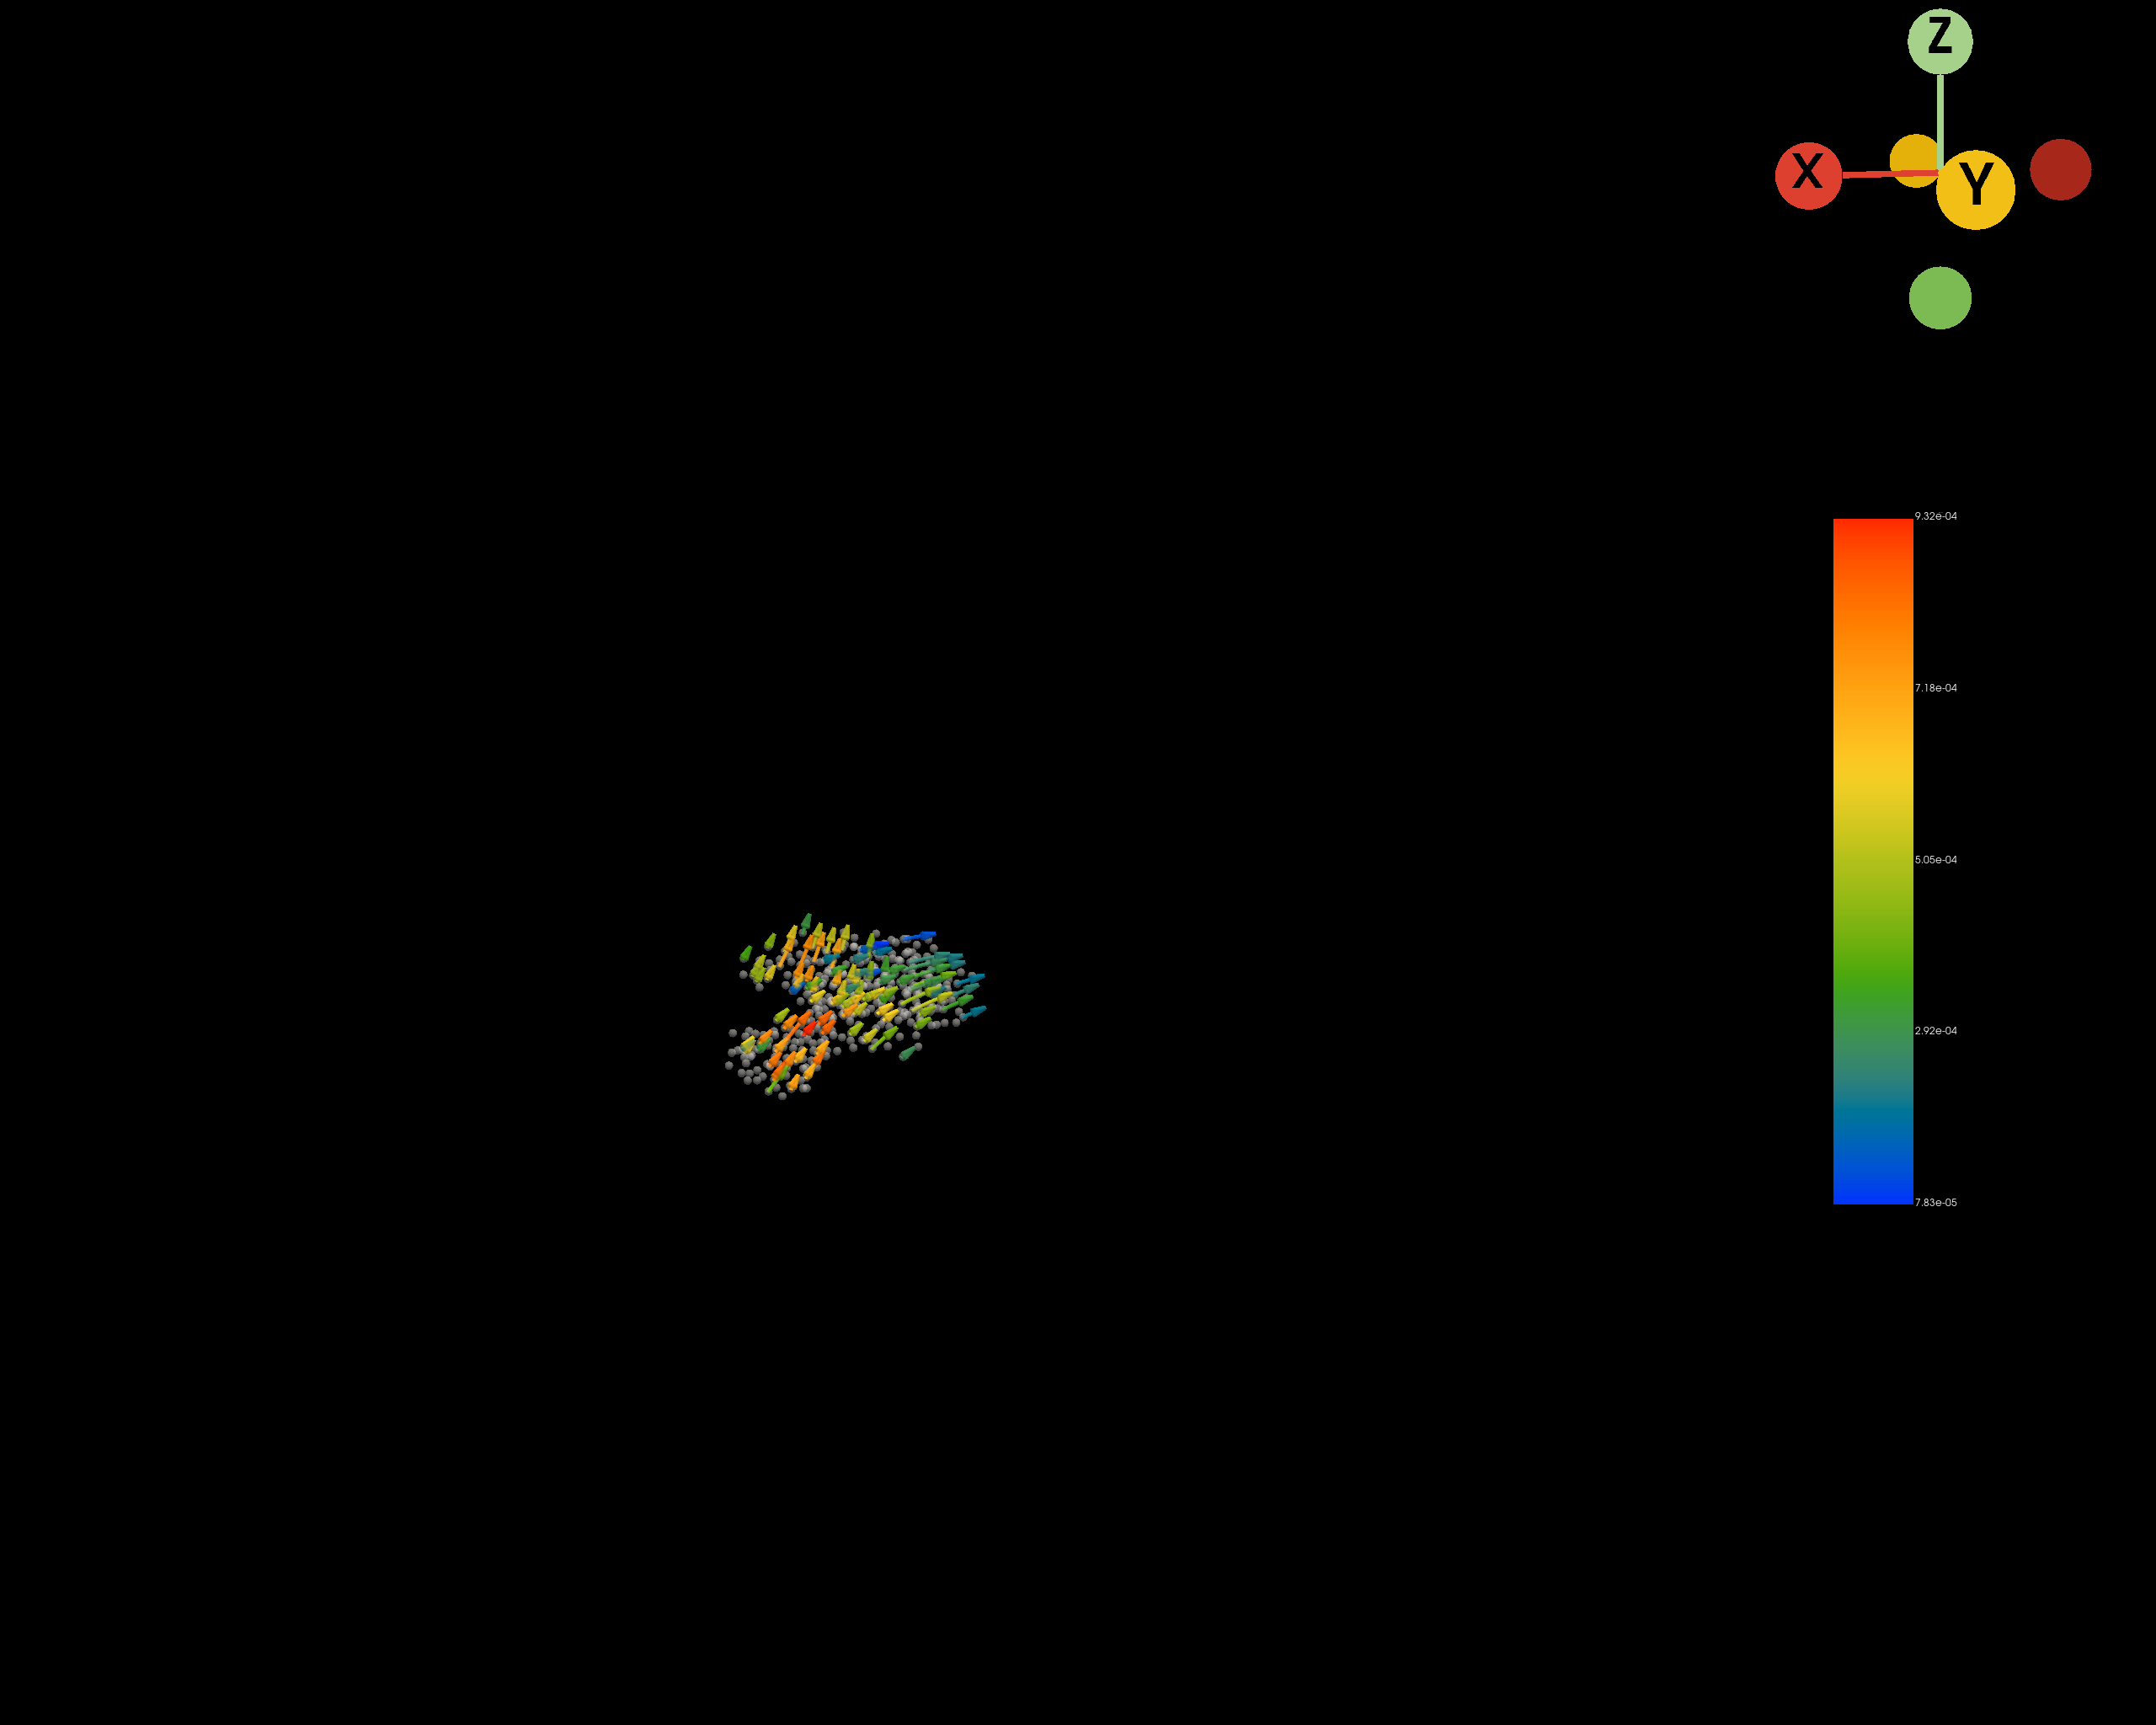

In [14]:
st.tdr.morphopath(
    adata=stage1_adata,
    vf_key="VecFld_morpho",
    key_added="fate_morpho",
    t_end=10000,
    interpolation_num=50,
    cores=20
)
trajectory_model, _ = st.tdr.construct_trajectory(
    adata=stage1_adata,
    fate_key="fate_morpho",
    n_sampling=100,
    sampling_method="trn",
    key_added="obs_index",
    label=np.asarray(stage1_adata.obs.index), # stage1_tissue_adata.uns["VecFld_morpho"]["V"][:, 2].flatten(),
)
stage1_adata.obs["V_z"] = stage1_adata.uns["VecFld_morpho"]["V"][:, 2].flatten()
st.tdr.add_model_labels(
    model=trajectory_model,
    key_added="trajectory",
    labels=np.asarray(stage1_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs["V_z"]),
    colormap="rainbow",
    where="point_data",
    inplace=True,
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([stage1_pc, trajectory_model]),
    key=["tissue", "trajectory"],
    opacity=[0.5, .5],
    model_style=["points", "wireframe"],
    model_size=[10, 5],
    colormap=["gainsboro", "rainbow"],
    show_legend=True,
    jupyter="static",
    background="black",
    window_size=(2560, 2048),
    cpo=cpo,
    filename=os.path.join(out_image_path, f"{morpho_id}_{tissue}_trajectory_pc_model.pdf")
)

In [15]:
# Save anndata
stage1_adata.X = stage1_adata.layers["X_counts"]
del stage1_adata.uns, stage1_adata.obsp, stage1_adata.var
stage1_adata.uns["__type"] = "UMI"
stage1_adata.write_h5ad(f"drosophila_{sample_id1}_germ_layer/h5ad/{sample_id1}_mapping_{tissue}.h5ad", compression="gzip",)
stage1_adata

AnnData object with n_obs × n_vars = 360 × 5819
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z'
    uns: '__type'
    obsm: '2d_realign_spatial', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', '3d_align_spatial', 'X_cells_mapping', 'V_cells_mapping'
    layers: 'X_counts', 'spliced', 'unspliced'